In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
import os

In [2]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
import torch

def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device)

In [4]:
device = get_default_device()

print(device)

cuda


In [5]:
def accuracy(net, testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = to_device(data, device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to(device)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.6f} %')

    return (100 * correct / total)

In [6]:
def classAccuracy(net, testloader, classes):
    # prepare to count predictions for each class
    net.eval()
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            inputs, labels = to_device(data, device)
            outputs = net(inputs)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred

def printClassAccuracy(net, testloader, classes):
    correct_pred, total_pred = classAccuracy(net, testloader, classes)
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.4f} %')

In [7]:
from tqdm.notebook import tqdm

def trainNN(net, criterion, optimizer, trainloader, validationloader = None, numEpochs = 20):
    epochLosses = []
    epochAccuracy = []
    epochValAccuracy = [] if validationloader is not None else None

    lossVal = 0
    accuracyVal = 0
    valAccuracyVal = 0

    for epoch in range(numEpochs):  # loop over the dataset multiple times
        correct = 0
        total = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            for data in tepoch:
                # get the inputs; data is a list of [inputs, labels]
                net.train()
                inputs, labels = to_device(data, device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                lossVal = loss.item()
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted.to(device)
                correct += (predicted == labels).float().sum()
                total += len(labels)
                accuracyVal = float(100 * correct / total)
                if validationloader is None:
                    tepoch.set_postfix(loss=lossVal, accuracy=accuracyVal) 
                else:
                    tepoch.set_postfix(loss=lossVal, accuracy=accuracyVal, validation=valAccuracyVal)
        
        epochLosses.append(lossVal)
        epochAccuracy.append(accuracyVal)
        if validationloader is not None:
            valAccuracyVal = accuracy(net, validationloader)
            epochValAccuracy.append(valAccuracyVal)
        
    return epochLosses, epochAccuracy, epochValAccuracy

In [8]:
import seaborn as sns
import pandas as pd
def accuracyplot(trainacc, valacc):
    data = pd.DataFrame({
        'x': np.arange(1, len(trainacc) + 1),
        'train': trainacc,
        'val': valacc
    })
    return sns.lineplot(x='x', y='value', hue='variable', data=pd.melt(data, ['x']))

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
valid_dir="./3b/seg_test/seg_test"
train_dir = "./3b/seg_train/seg_train"
test_dir = "./3b/seg_test/seg_test"
bs = 128

In [11]:
num_classes = len(os.listdir(valid_dir))
num_classes

6

In [12]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=valid_dir, transform=image_transforms['test'])
}

In [13]:
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [14]:
classes = [idx_to_class[i] for i in range(num_classes)]

In [15]:
train_data_size, valid_data_size, test_data_size

(14034, 3000, 3000)

In [16]:
alexnet = models.alexnet(pretrained=True, progress=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
for param in alexnet.parameters():
    param.requires_grad = False

In [18]:
import torch.nn as nn

alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.005, momentum=0.9)

In [20]:
alexnet = to_device(alexnet, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


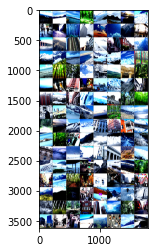

mountain glacier sea   forest glacier mountain sea   glacier street street forest buildings sea   buildings mountain buildings buildings mountain buildings street street street street glacier mountain glacier sea   sea   glacier glacier glacier forest sea   forest forest glacier buildings mountain buildings forest mountain street buildings street sea   glacier glacier street buildings glacier street glacier glacier buildings forest forest street buildings glacier glacier mountain forest mountain sea   forest sea   glacier glacier buildings buildings buildings mountain sea   forest street glacier sea   glacier street glacier buildings mountain sea   glacier buildings buildings mountain mountain glacier glacier sea   street street sea   sea   forest street glacier forest street buildings street buildings street mountain mountain forest street sea   mountain glacier forest forest forest forest buildings buildings glacier forest street buildings street buildings sea   mountain sea   glacie

In [21]:
import torchvision
# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(bs)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


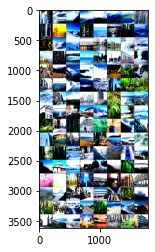

buildings sea   glacier mountain mountain mountain glacier forest forest sea   mountain forest mountain sea   forest glacier forest glacier mountain sea   street mountain sea   glacier mountain forest glacier sea   street buildings buildings street street mountain glacier sea   mountain street forest street street mountain glacier mountain glacier buildings forest forest glacier street mountain glacier buildings forest sea   mountain buildings sea   street mountain glacier forest sea   glacier forest street forest glacier forest sea   glacier street buildings mountain street sea   forest glacier sea   glacier forest forest glacier street mountain mountain buildings mountain mountain buildings glacier street glacier mountain forest sea   sea   sea   forest buildings sea   street buildings street mountain glacier street street buildings buildings forest glacier forest street glacier street forest sea   glacier sea   street sea   glacier buildings sea   forest forest buildings


In [22]:
# get some random validation images
dataiter = iter(valid_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(bs)))

In [23]:
loss, trAcc, valAcc = trainNN(alexnet, criterion, optimizer, train_data_loader, valid_data_loader, numEpochs=10)

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

<AxesSubplot:xlabel='x', ylabel='value'>

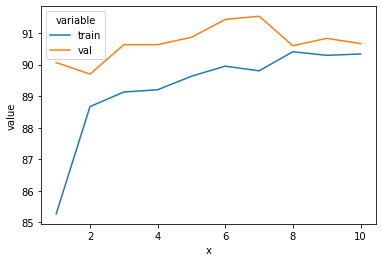

In [24]:
accuracyplot(trAcc, valAcc)

In [25]:
printClassAccuracy(alexnet, test_data_loader, classes)

Accuracy for class: buildings is 86.9565 %
Accuracy for class: forest is 99.1561 %
Accuracy for class: glacier is 81.5552 %
Accuracy for class: mountain is 84.1905 %
Accuracy for class: sea   is 97.8431 %
Accuracy for class: street is 95.4092 %


In [26]:
accuracy(alexnet, test_data_loader)

90.66666666666667

In [56]:
resnet = models.resnet50(pretrained=True, progress=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
for param in resnet.parameters():
    param.requires_grad = False

In [58]:
import torch.nn as nn

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 6)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [59]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

In [60]:
resnet = to_device(resnet, device)

In [61]:
loss, trAcc, valAcc = trainNN(resnet, criterion, optimizer, train_data_loader, valid_data_loader, numEpochs=25)

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/110 [00:00<?, ?batch/s]

<AxesSubplot:xlabel='x', ylabel='value'>

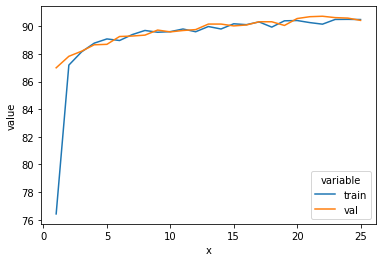

In [62]:
accuracyplot(trAcc, valAcc)

In [63]:
printClassAccuracy(resnet, test_data_loader, classes)

Accuracy for class: buildings is 91.7620 %
Accuracy for class: forest is 98.5232 %
Accuracy for class: glacier is 84.8101 %
Accuracy for class: mountain is 80.9524 %
Accuracy for class: sea   is 95.4902 %
Accuracy for class: street is 92.6148 %
